In [2]:
# !pip install torchtext
# !pip install evaluate
# !pip install bert_score

# Machine Translation. Реализация нейросетевых алгоритмов для задачи машинного перевода текста с английского языка на немецкий

In [3]:
import pandas as pd
import numpy as np
from tokenizers import BertWordPieceTokenizer
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

from evaluate import load

In [4]:
df = pd.read_csv('/content/drive/MyDrive/otus_machine_translation/multi30k_train.csv')
df.head()

,en,de
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


In [5]:
df.shape

(29000, 2)

### Предобработка текста

1. **Очистка текста**
    - Удаляем специальные символы, которые не несут смысловой нагрузки (например, HTML-теги, лишние пробелы, пунктуацию, если она не нужна).
    - Приводим текст к нижнему регистру.
    - Удаляем или заменяем редкие символы (например, эмодзи, символы валют и т.д.).
    - **Важно**: Для задачи машинного перевода **удалять стоп-слова в двух языках не нужно**.
    Стоп-слова — это часто встречающиеся, но малозначимые слова, такие как артикли (например, "the", "a"), предлоги (например, "in", "on"), союзы (например, "and", "but") и другие слова, которые в основном используются для связывания других слов в предложении. В машинном переводе контекст важен, и стоп-слова могут быть важны для правильной передачи смысла.


2. **Лемматизация**

    В нашем случае, мы будем использовать предобученные токенизаторы, поэтому лемматизация не потребуется.

    **Причины**:
    1) **Использование токенизации на уровне субслов (subword tokenization)**

    Современные предобученные модели, такие как **BERT**, **GPT**, **T5** и другие, используют токенизацию на уровне субслов (например, **BPE** — Byte Pair Encoding, **WordPiece** или **SentencePiece**). Это позволяет моделям эффективно справляться с морфологически сложными словами и редкими словами, а также с новым словарем, который не был встречен в процессе обучения.

    Например, слово "unhappiness" может быть разбито на несколько частей: "un", "happi", "ness". Это позволяет модели обрабатывать даже редкие или не встречавшиеся слова, не требуя лемматизации, потому что модель будет работать не с целыми словами, а с их частями.

    2) **Контекстное представление в больших языковых моделях**

    Большие языковые модели, такие как **BERT**, **GPT** и другие трансформеры, используют контекстное представление слов, что означает, что модель может различать разные формы слова в зависимости от контекста, в котором оно используется.

    Например, для модели **BERT** слово "running" в контексте предложения "She is running fast" и "I enjoy running" будет интерпретироваться по-разному. Таким образом, модель может понять, что слово "running" в одном контексте является герундием (от существительного "run"), а в другом — глаголом в настоящем времени.

    По этому, лемматизация не требуется, поскольку модель сама извлекает значение слова из контекста, независимо от его формы.

    3) **Токенизация на уровне субслов и лемматизация**

    Когда модель использует токенизацию на уровне субслов, она автоматически справляется с разными морфологическими вариациями, которые лемматизация обычно решает. Например, если слово "dogs" не встречается в словаре модели, оно будет разбито на два подслова: "dog" и "s", и модель будет обрабатывать их как два отдельных токена. Это позволяет модели понимать, что "dogs" и "dog" связаны, даже без явной лемматизации.

3. **Токенизация**

    Будем использовать предобученный токенизатор.


In [6]:
def clean_text(raw_text):

  # Удаляем HTML-теги
  # < - начало HTML-тега
  # [^>]+ => [] - набор символов
  #          [^..] - любой символ кроме
  #          [^>] - любой символ кроме >
  #           +  - это квантификатор, который означает "один или более раз".
  #          [^>]+ - означает "один или более символов, кроме >".
  #          > - конец HTML-тега
  clean_text = re.sub(r'<[^>]+>', ' ', raw_text)

  # Удаляем URL-ы
  # http - начало URL
  # \S+ - удаляем один или несколько любых непробельных символов
  # \S+ захватывает все символы после http, пока не встретится пробел.
  clean_text = re.sub(r'http\S+', ' ', clean_text)

  # Удаляем все знаки пунктуации и осталяем только буквы, цифры и пробелы
  # \w - буквы
  # \d - цифры
  clean_text = re.sub(r'[^\w\d]', ' ', clean_text)

  # Удаляем лищние пробелы
  # \s - любой пробельный символ (пробел, табуляция, конец строки и т.п.)
  clean_text = re.sub(r'\s+', ' ',clean_text)

  clean_text = clean_text.lower()

  return clean_text

In [ ]:
# re.sub(r'<[^>]+>', '', '<sfdf>')

In [ ]:
# re.sub(r'http\S+', ' ', 'https://colab.research.google.com/drive/12Q-EnKDZoJ_6HSvcSnRbuKdVRyb0YPC1#scrollTo=gKS5EjNbtCaP')

In [ ]:
# re.sub(r'[^\w\d]', ' ', "Hello, world! This is a test: 123.")

In [ ]:
# re.sub(r'\s+', ' ','23     fr     342')

In [7]:
df['en_clean'] = df['en'].apply(clean_text)
df['de_clean'] = df['de'].apply(clean_text)
df.head()

,en,de,en_clean,de_clean
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...,two young white males are outside near many bu...,zwei junge weiße männer sind im freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...,several men in hard hats are operating a giant...,mehrere männer mit schutzhelmen bedienen ein a...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...,a little girl climbing into a wooden playhouse,ein kleines mädchen klettert in ein spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...,a man in a blue shirt is standing on a ladder ...,ein mann in einem blauen hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.,two men are at the stove preparing food,zwei männer stehen am herd und bereiten essen zu


In [8]:
def train_tokenizer(language,
                    path_to_save_model):

  tokenizer = BertWordPieceTokenizer(vocab = None,
                                     unk_token = '[UNK]',  # токен неизвестного слова
                                     sep_token = '[SEP]',  # токен конца предложения
                                     cls_token = '[CLS]',  # токен начала предложения
                                     pad_token = '[PAD]',
                                     mask_token = '[MASK]',
                                     clean_text = True,    # очистить текст от знаков препинания и других ненужных символов
                                     handle_chinese_chars = True, # обрабатывать китайские иероглифы
                                     strip_accents = True,   # удалить знаки препинания
                                     lowercase = True,       # привести к нижнему регистру
                                     wordpieces_prefix = '##') # префикс для частей слова.

  column = f'{language}_clean'
  tokenizer.train_from_iterator(iterator=df[column].values,
                                min_frequency = 5,
                                special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'])

  # Сохранение токенизатора
  tokenizer.save_model(path_to_save_model)

  print("Размер словаря ", tokenizer.get_vocab_size())

In [ ]:
# help(BertWordPieceTokenizer)

In [9]:
PATH_TO_TOKENIZER_EN = '/content/drive/MyDrive/otus_machine_translation/tokenizer_en_model'
PATH_TO_TOKENIZER_DE = '/content/drive/MyDrive/otus_machine_translation/tokenizer_de_model'

In [ ]:
# train_tokenizer(language = 'en',
#                 path_to_save_model = PATH_TO_TOKENIZER_EN)

In [ ]:
# train_tokenizer(language = 'de',
#                 path_to_save_model = PATH_TO_TOKENIZER_DE)

In [10]:
tokenizer_en = BertWordPieceTokenizer.from_file(vocab = f'{PATH_TO_TOKENIZER_EN}/vocab.txt')
tokenizer_de = BertWordPieceTokenizer.from_file(vocab = f'{PATH_TO_TOKENIZER_DE}/vocab.txt')

In [11]:
tokenizer_en.encode("This is an example sentence.").ids

[2, 707, 96, 88, 1705, 343, 3560, 2142, 184, 1, 3]

In [ ]:
# Загрузка токенизатора в `transformers`
# from transformers import BertTokenizerFast

# tokenizer_en = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = PATH_TO_TOKENIZER_EN)
# tokenizer_de = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = PATH_TO_TOKENIZER_DE)


# tokenizer_en.encode_plus(text = "This is an example sentence.",
#                          padding = True,
#                          truncation = True,
#                          max_length = 20,
#                          return_tensors = 'pt',
#                          return_attention_mask = True
#                          )

In [12]:
tokenizer_en.encode("This is an example sentence.").tokens

['[CLS]',
 'this',
 'is',
 'an',
 'exam',
 '##ple',
 'sen',
 '##ten',
 '##ce',
 '[UNK]',
 '[SEP]']

In [13]:
tokenizer_en.decode(tokenizer_en.encode("This is an example sentence.").ids)

'this is an example sentence'

In [ ]:
# help(tokenizer_en)

In [14]:
df['en_sentence_len'] = df['en_clean'].apply(lambda x: len(tokenizer_en.encode(x).tokens))
df['de_sentence_len'] = df['de_clean'].apply(lambda x: len(tokenizer_de.encode(x).tokens))
df.head()

,en,de,en_clean,de_clean,en_sentence_len,de_sentence_len
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...,two young white males are outside near many bu...,zwei junge weiße männer sind im freien in der ...,11,15
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...,several men in hard hats are operating a giant...,mehrere männer mit schutzhelmen bedienen ein a...,14,15
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...,a little girl climbing into a wooden playhouse,ein kleines mädchen klettert in ein spielhaus ...,11,12
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...,a man in a blue shirt is standing on a ladder ...,ein mann in einem blauen hemd steht auf einer ...,16,16
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.,two men are at the stove preparing food,zwei männer stehen am herd und bereiten essen zu,10,11


In [ ]:
# tokenizer_en.get_vocab()

In [15]:
df.shape

(29000, 6)

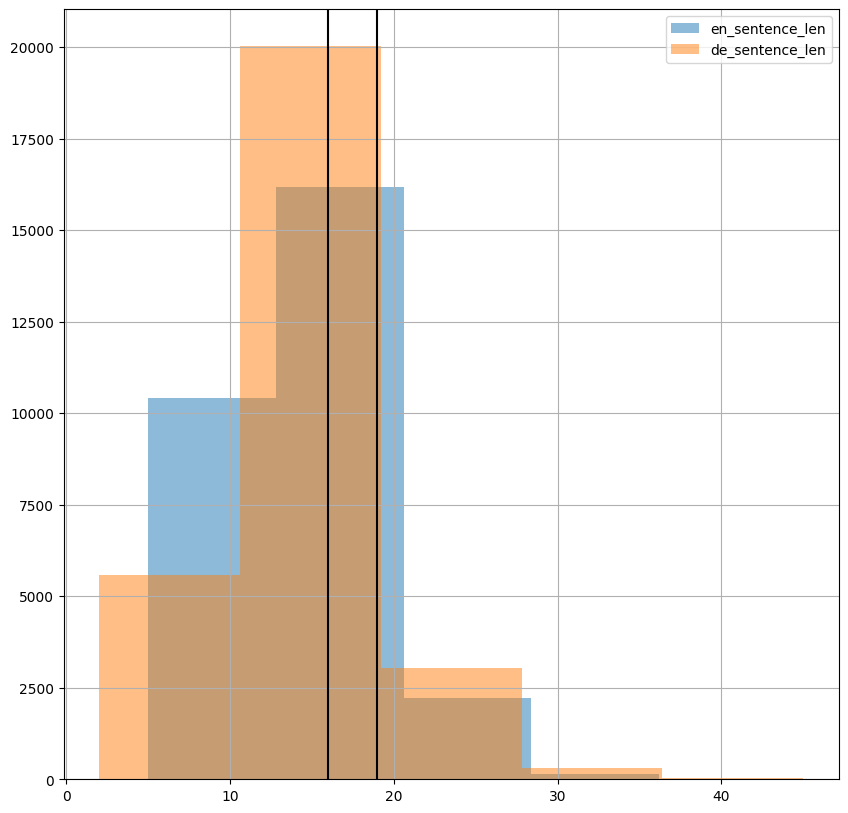

In [16]:
plt.figure(figsize=(10,10))
df['en_sentence_len'].hist(bins = 5, legend = "en", alpha=0.5)
df['de_sentence_len'].hist(bins = 5, legend = "de", alpha=0.5)
plt.axvline(19, color = 'black')
plt.axvline(16, color = 'black')
plt.show()

Для английского языка выберем длину последовательности равной 16 токенов, для немецкого - 19.

In [17]:
MAX_LENGTH_EN = 16
MAX_LENTCH_DE = 19

In [18]:
tokenizer_en.enable_truncation(max_length = MAX_LENGTH_EN)
tokenizer_en.enable_padding(length = MAX_LENGTH_EN)

tokenizer_de.enable_truncation(max_length = MAX_LENTCH_DE)
tokenizer_de.enable_padding(length = MAX_LENTCH_DE)

#### Padding mask

В задачах NLP маска паддинга нужна, чтобы модель корректно обрабатывала последовательности разной длины, игнорируя искусственно добавленные "пустые" токены (padding).

В NLP последовательности (например, предложения) обычно имеют разную длину, но модели (например, трансформеры) требуют фиксированного размера входа. Чтобы подавать данные батчами, короткие последовательности дополняются специальным токеном `<pad>` до нужной длины.

**Пример:**


    Предложение 1: ["Я", "люблю", "NLP"] (длина = 3)

    Предложение 2: ["Трансформеры", "это", "круто", "!"] (длина = 4)


Если максимальная длина батча = 4, то первое предложение дополняется `<pad>`:  
`["Я", "люблю", "NLP", "<pad>"]`.

**Проблема, которую решает padding mask**

Без маски модель обращала бы внимание на `<pad>`-токены, что приводит к двум проблемам:

1. **Вычислительная неэффективность**: модель тратит ресурсы на обработку бессмысленных токенов.
2. **Искажение результатов**: padding-токены могут повлиять на веса внимания (attention) или выходы слоёв (например, в LSTM/GRU).

**Пример:**  
В механизме self-attention трансформера каждый токен взаимодействует со всеми остальными, включая `<pad>`. Без маски это приведёт к "мусорным" значениям внимания.

**Как работает padding mask?**

Маска указывает модели, какие токены являются настоящими, а какие — padding'ом. Обычно это бинарный тензор, где:

- `0` (или `False`) — реальный токен,
- `1` (или `True`) — padding (игнорируется).

**Пример:**

```python
sequences = [
    ["Я", "люблю", "NLP", "<pad>"],  # Длина 4 (3 реальных + 1 pad)
    ["Трансформеры", "это", "круто", "!"]  # Длина 4 (все реальные)
]

padding_mask = [
    [0, 0, 0, 1],  # Маска для первого предложения
    [0, 0, 0, 0]   # Маска для второго
]
```

**Где именно применяется маска?**

В механизме внимания, к padding-токенам применяется маска, которая "закрывает" их (например, устанаваливает их веса в -inf).


**Итог**

Padding mask — это технически простой, но критически важный механизм для:

  1.  Игнорирования "пустых" токенов в батчах.


  2.  Корректной работы attention-механизмов.


  3.  Эффективности вычислений (экономия памяти и времени).

Без неё даже сильная модель (например, BERT или GPT) даст плохие результаты на реальных данных с последовательностями разной длины.

In [21]:
token_ids = torch.tensor([[   2,   15, 3655,  979,   97,  820,  444,  412,   81,  295, 0,   0, 0,    3]])
token_ids

tensor([[   2,   15, 3655,  979,   97,  820,  444,  412,   81,  295,    0,    0,
            0,    3]])

In [ ]:
# token_ids.squeeze().tolist()

In [ ]:
# token_ids.squeeze().flip(dims = (0, ))

In [ ]:
# torch.zeros(14,dtype=bool)

In [19]:
def create_padding_mask(token_ids):

  token_ids_reversed = token_ids.squeeze().flip(dims = (0,))

  # length = token_ids_reversed.shape[0]

  padding_mask_reversed = torch.zeros(len(token_ids_reversed), dtype=bool)

  for i, token_id in enumerate(token_ids_reversed):
    if token_id == 0:
      padding_mask_reversed[i] = True

  return padding_mask_reversed.flip(dims = (0,))

In [22]:
create_padding_mask(token_ids)

tensor([False, False, False, False, False, False, False, False, False, False,
         True,  True,  True, False])

#### Dataset

In [ ]:
# help(tokenizer_en)

In [23]:
class CustomDataset(Dataset):
  def __init__(self, data, tokenizer_en, tokenizer_de):
    self.data = data
    self.tokenizer_en = tokenizer_en
    self.tokenizer_de = tokenizer_de
    self.en_seq_length = 15
    self.de_seq_length = 17

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    source_ids = torch.tensor(self.tokenizer_en.encode(sequence = self.data.iloc[index]['en_clean']).ids)
    target_ids = torch.tensor(self.tokenizer_de.encode(sequence = self.data.iloc[index]['de_clean']).ids)

    return {'en_ids': source_ids,
            'en_padding_mask': create_padding_mask(source_ids),
            'de_ids':  target_ids,
            'de_padding_mask': create_padding_mask(target_ids)}

In [ ]:
# dataset = CustomDataset(data = df,
#                         tokenizer_en = tokenizer_en,
#                         tokenizer_de = tokenizer_de)

In [ ]:
# dataset[5]

### Transformer

In [24]:
# import torch
import torch.nn as nn
from torch import Tensor
import math

#### **Positional Encoding**

В архитектуре трансформер эмбеддинги всех входящих токенов обрабатываются параллельно. Таким образом, нейросеть не получает информацию о порядке следования токенов в предложении, которая важна для понимания его смысла:

- cat runs horse
- horse runs cat

**Как учитывать порядок слов в предложении?**

Ответ: будем добавлять к эмбеддингам входных токенов вектор, содержащий информацию о позиции каждого токена в предложении.

---

##### **Определение**

**Positional Encoding (PE)** — это механизм, который добавляет информацию о позиции элементов в последовательности к их векторным представлениям в архитектуре трансформера. Поскольку трансформеры не используют рекуррентные или свёрточные слои, они по умолчанию не учитывают порядок данных. PE решает эту проблему, позволяя модели различать расположение токенов.

---

##### **Векторы PE в оригинальной статье "Attention is All You Need"**:

1) **Фиксированные и не обучаемые**: В оригинальной статье используются предопределённые синусоидальные функции для генерации PE. Эти векторы не обучаются — они вычисляются по формуле и остаются неизменными в течение всего обучения.

2) **Одинаковы для одинаковых позиций**: Для всех последовательностей одинаковой длины позиционные кодировки для, например, 3-го токена будут одними и теми же, независимо от содержимого последовательности.

**Пример**: Для позиции `pos=5` вектор PE(5) всегда будет одинаковым, будь то предложение "I love NLP" или "The weather is nice".

---

##### **Пример использования**

Рассмотрим предложение **"The cat sat on the mat"**:

Каждому слову ("The", "cat", "sat", ...) сопоставляется эмбеддинг (вектор).

К каждому эмбеддингу добавляется **positional encoding**, уникальный для позиции слова:

- "The" (позиция 0):  
  `PE(0) = [sin(0/10000^(0/512)), cos(0/10000^(0/512)), ..., sin(0/10000^(256/512))]`

- "cat" (позиция 1):  
  `PE(1) = [sin(1/10000^(0/512)), cos(1/10000^(0/512)), ...]`

Модель обрабатывает комбинированные векторы (эмбеддинг + PE), учитывая и семантику слов, и их порядок.

---

##### **Что было бы без Positional Encoding?**

- Модель воспринимала бы последовательность как неупорядоченный набор токенов.

- Задачи, зависящие от порядка (например, машинный перевод или генерация текста), стали бы нерешаемыми. Например, перевод "I love you" и "You love I" давал бы одинаковый результат.

- Производительность трансформера упала бы до уровня моделей, игнорирующих контекст (например, bag-of-words).


In [25]:
class PositionalEncoding(nn.Module):

    def __init__(self,
                 d_model: int,
                 dropout: float = 0.1,
                 max_len: int = 10):

        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
# torch.arange(10)

In [ ]:
# torch.zeros(10, 1, 256)

In [ ]:
# pe = PositionalEncoding(d_model = 512,
#                         dropout = 0.1,
#                         max_len = 10)

In [ ]:
# x = torch.rand(10, 2, 512)
# x

In [ ]:
# pe.forward(x)

#### Model init

In [26]:
class Transformer(nn.Module):

  def __init__(self,
               source_seq_len,
               target_seq_len,
               source_vocab_size,
               target_vocab_size,
               embedding_dim = 512,
               nhead = 8,
               dim_feedforward = 2048,
               dropout = 0.1,
               num_encoder_layers=1,
               num_decoder_layers=1):

    super(Transformer, self).__init__()

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.source_seq_len = source_seq_len

    self.target_seq_len = target_seq_len

    # Создание верхнетреугольной маски для декодера
    # РАЗМЕРНОСТЬ target_subsequent_mask [seq_len, seq_len]
    # НУЖНА ЛИ МАСКА ВНИМАНИЯ ДЛЯ ЭНКОДЕРА ТРАНСФОРМЕРА
    self.target_subsequent_mask = nn.Transformer().generate_square_subsequent_mask(target_seq_len).to(self.device)

    self.embedding_dim = embedding_dim

    self.source_embedding = nn.Embedding(num_embeddings = source_vocab_size, embedding_dim = embedding_dim)

    self.target_embedding = nn.Embedding(num_embeddings = target_vocab_size, embedding_dim = embedding_dim)

    self.source_positional_encoding = PositionalEncoding(d_model = embedding_dim, max_len = source_seq_len)

    self.target_positional_encoding = PositionalEncoding(d_model = embedding_dim, max_len = target_seq_len)

    self.transformer = nn.Transformer(d_model = embedding_dim,
                                      nhead = nhead,
                                      num_encoder_layers = num_encoder_layers,
                                      num_decoder_layers = num_decoder_layers,
                                      dim_feedforward = dim_feedforward,
                                      dropout = dropout,
                                      batch_first=False)

    self.linear = nn.Linear(embedding_dim, target_vocab_size)

  def forward(self,
              source_ids,
              target_ids,
              source_padding_mask,
              target_padding_mask):

    # РАЗМЕРНОСТЬ source_ids [batch_size, source_seq_len]
    # РАЗМЕРНОСТЬ source_padding_mask [batch_size, source_seq_len]

    # РАЗМЕРНОСТЬ source_embeddings [batch_size, source_seq_len, embedding_dim]
    source_embeddings = self.source_embedding(input = source_ids)
    target_embeddings = self.target_embedding(input = target_ids)

    # РАЗМЕРНОСТЬ source_embeddings [source_seq_len, batch_size, emb_dim]
    source_embeddings = source_embeddings.permute(1,0,2)
    target_embeddings = target_embeddings.permute(1,0,2)

    # РАЗМЕРНОСТЬ source_embeddings [source_seq_len, batch_size, emb_dim]
    source_embeddings = self.source_positional_encoding.forward(x = source_embeddings)
    target_embeddings = self.target_positional_encoding.forward(x = target_embeddings)

    # РАЗМЕРНОСТЬ logits [target_seq_len, batch_size, emb_dim]
    logits = self.transformer.forward(src=source_embeddings,
                                      tgt = target_embeddings,
                                      tgt_mask = self.target_subsequent_mask,
                                      src_key_padding_mask = source_padding_mask,
                                      tgt_key_padding_mask =  target_padding_mask)

    # РАЗМЕРНОСТЬ logits [target_seq_len, batch_size, target_vocab_size]
    logits = self.linear(logits)
    return logits


  def generate_translation(self, source_sentence, tokenizer_source, tokenizer_target):
    # Предобработка текста source_sentence (lower, re.sub)
    source_sentence = clean_text(source_sentence)

    # РАЗМЕРНОСТЬ source_ids [batch_size = 1, source_seq_len]
    source_ids = torch.tensor(tokenizer_source.encode(source_sentence).ids).unsqueeze(dim=0).to(self.device)

    # РАЗМЕРНОСТЬ source_padding_mask [batch_size = 1, source_seq_len]
    source_padding_mask = create_padding_mask(source_ids)
    source_padding_mask = source_padding_mask.unsqueeze(0).to(self.device)

    # Инициализация первой последовательности для предсказания (начало последовательности)
    predicted_ids = [tokenizer_target.token_to_id('[CLS]')] + [tokenizer_target.token_to_id('[PAD]')] * (self.target_seq_len - 1)

    # Генерация последовательности
    for i in range(self.target_seq_len - 1):

      # predicted_ids - РАЗМЕРНОСТЬ [batch_size = 1, target_seq_len]
      predicted_ids_tensor = torch.LongTensor(predicted_ids).unsqueeze(0).to(self.device)

      # РАЗМЕРНОСТЬ target_padding_mask [batch_size = 1, target_seq_len]
      target_padding_mask = torch.zeros((1, self.target_seq_len), dtype=torch.bool).to(self.device)
      target_padding_mask[:, i + 1:] = True  # Все токены после i считаются паддингом

      # РАЗМЕРНОСТЬ logits [target_seq_len, batch_size, target_vocab_size], распределение вероятностей
      logits = self.forward(source_ids=source_ids,
                            target_ids=predicted_ids_tensor,
                            source_padding_mask=source_padding_mask,
                            target_padding_mask=target_padding_mask)

      # Получаем токен с наибольшей вероятностью на текущем шаге
      predicted_id = logits.argmax(dim=-1)[i, :].item()

      # Обновление predicted_ids
      predicted_ids_tensor = predicted_ids_tensor.squeeze(0)
      predicted_ids_tensor[i + 1] = predicted_id

      # Обновляем список предсказанных ID
      predicted_ids = predicted_ids_tensor.tolist()

    # Индекс EOS (конец последовательности)
    EOS_IDX = tokenizer_target.token_to_id('[SEP]')

    generated_ids = []

    # Вывод сгенерированной последовательности
    for t in predicted_ids:

      if t != EOS_IDX:
          # print(tokenizer_target.id_to_token(t), end=' ')
          generated_ids.append(tokenizer_target.id_to_token(t))
      else:
          break

    return ' '.join(generated_ids[1:]) # не будем выводить токен [CLS] при генерации


In [ ]:
# torch.zeros((1, 3), dtype = bool)

In [ ]:
# embed = nn.Embedding(5, 10)
# embed(input = torch.tensor([0, 4]))

In [ ]:
# help(embed)

In [27]:
# ОТЛАДКА
# Параметры
embedding_dim = 512
source_seq_len = MAX_LENGTH_EN
target_seq_len = MAX_LENTCH_DE

source_vocab_size = tokenizer_en.get_vocab_size()
target_vocab_size = tokenizer_de.get_vocab_size()

n_head = 8
fc_dim = 2048
dropout = 0.1
num_encoder_layers = 1
num_decoder_layers = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 2


# Входные данные
source_ids = torch.randint(0, source_vocab_size, (batch_size, source_seq_len)).to(device)
target_ids = torch.randint(0, target_vocab_size, (batch_size, target_seq_len)).to(device)


source_padding_mask = torch.tensor([[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True],
                                    [False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True]]).to(device)

target_padding_mask = torch.tensor([[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True],
                                    [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True]]).to(device)

In [ ]:
# target_padding_mask.shape

In [ ]:
# source_ids.shape

In [ ]:
# target_ids

In [ ]:
# help(nn.Transformer)

In [ ]:
# Создаем экземпляр Transformer
# model = Transformer(source_seq_len = source_seq_len,
#                     target_seq_len = target_seq_len,
#                     source_vocab_size = source_vocab_size,
#                     target_vocab_size = target_vocab_size).to(device)

In [ ]:
# model.forward(source_ids = source_ids,
#               target_ids = target_ids,
#               source_padding_mask = source_padding_mask,
#               target_padding_mask = target_padding_mask)

In [ ]:
# model.generate_translation(source_sentence = 'I love my job',
#                            tokenizer_source = tokenizer_en,
#                            tokenizer_target = tokenizer_de)

#### Metrics

In [28]:
bertscore = load("bertscore")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [29]:
def metrics(predicted_ids, target_ids, tokenizer_target):
    # выбираем argmax для каждого массива размерности vocab_size в массиве seq_len
    # массив предсказанных индексов токенов последвоательности

    # predicted_sequences - РАЗМЕРНОСТЬ [seq_len - 1, batch_size, vocab_size]
    # target_sequences - РАЗМЕРНОСТЬ [seq_len - 1, batch_size]

    # [seq_len - 1, batch_size]
    predict = torch.argmax(predicted_ids, -1)

    predicted_tokens = []
    predicted_tokens_for_bert_score = []

    target_tokens = []

    for i in range(predict.shape[1]):

        predict_token_id = predict[:, i].tolist()

        predict_token = tokenizer_target.decode(predict_token_id)

        target_token_id = target_ids[:,i].tolist()

        target_token = tokenizer_target.decode(target_token_id)

        predicted_tokens.append([predict_token])

        predicted_tokens_for_bert_score.append(predict_token)

        target_tokens.append(target_token)

    bleu_1 = corpus_bleu(predicted_tokens, target_tokens, weights = (1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(predicted_tokens, target_tokens, weights = (0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(predicted_tokens, target_tokens, weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0))
    bleu_4 = corpus_bleu(predicted_tokens, target_tokens, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = SmoothingFunction().method1)

    bert_score = bertscore.compute(predictions=predicted_tokens_for_bert_score,
                                   references=target_tokens,
                                   lang = 'en',
                                   model_type="roberta-large")


    precision = np.array(bert_score['precision']).mean()
    recall = np.array(bert_score['recall']).mean()
    f1 = np.array(bert_score['f1']).mean()

    return {'bleu_1': bleu_1,
            'bleu_2':bleu_2,
            'bleu_3':bleu_3,
            'bleu_4':bleu_4,
            'bert_precision': precision,
            'bert_recall': recall,
            'bert_f1': f1,
           }

In [30]:
# Предсказанные последовательности (predicted_sequences)
predicted_sequences = torch.tensor([
                                        [[0.1, 0.2, 0.7], [0.3, 0.6, 0.1], [0.8, 0.1, 0.1]],
                                        [[0.2, 0.4, 0.4], [0.7, 0.2, 0.1], [0.1, 0.8, 0.1]]
                                    ]).transpose(0, 1)

print(predicted_sequences.shape)
print(predicted_sequences)

torch.Size([3, 2, 3])
tensor([[[0.1000, 0.2000, 0.7000],
         [0.2000, 0.4000, 0.4000]],

        [[0.3000, 0.6000, 0.1000],
         [0.7000, 0.2000, 0.1000]],

        [[0.8000, 0.1000, 0.1000],
         [0.1000, 0.8000, 0.1000]]])


In [31]:
# Целевые последовательности (target_sequences)
target_sequences = torch.tensor([
                                    [2, 1, 0],
                                    [1, 0, 1]
                                ]).transpose(0, 1)

print(target_sequences.shape)
print(target_sequences)

torch.Size([3, 2])
tensor([[2, 1],
        [1, 0],
        [0, 1]])


In [32]:
metrics_score = metrics(predicted_sequences, target_sequences, tokenizer_target= tokenizer_de)
print(f"BLEU score: {metrics_score}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


BLEU score: {'bleu_1': 0, 'bleu_2': 0, 'bleu_3': 0, 'bleu_4': 0, 'bert_precision': np.float64(0.0), 'bert_recall': np.float64(0.0), 'bert_f1': np.float64(0.0)}


#### Train

Два важных момента, которые необходимо учитывать при обучении модели:

#### 1. **Общий процесс обучения языковой модели**

Языковая модель (в том числе Transformer) **учится предсказывать следующий токен в последовательности на основе предыдущих**.

Давайте разберём обучение модели машинного перевода на примере целых фраз, чтобы было понятно, как выглядит X (вход модели) и y (целевые значения для обучения).

**Пример данных**

Возьмём два предложения для перевода с английского на немецкий:

Английский (источник): "I love cats"

Немецкий (цель): "Ich liebe Katzen"



**Токенизация (упрощённо)**

Допустим, после токенизации у нас получилось:

en_ids = [<SOS>, "I", "love", "cats", <EOS>] (длина = 5)

de_ids = [<SOS>, "Ich", "liebe", "Katzen", <EOS>] (длина = 4)



**Структура входов и выхода Transformer (Seq2Seq)**

| Компонент       | Пример данных (`"I love cats" → "Ich liebe Katzen"`) | Роль                          | Размерность      |
|-----------------|----------------------------------------------------|-------------------------------|------------------|
| **Вход энкодера (X₁)** | `[<SOS>, "I", "love", "cats", <EOS>]`             | Исходное предложение для перевода | `[seq_len=5]`    |
| **Вход декодера (X₂)** | `[<SOS>, "Ich", "liebe", "Katzen"]`               | Целевой текст без `<EOS>` (для Teacher Forcing) | `[seq_len=4]`    |
| **Целевой выход (y)**  | `["Ich", "liebe", "Katzen", <EOS>]`               | Ожидаемый перевод (сдвинутый X₂)  | `[seq_len=4]`    |

**Пояснение**:
- **X₁** (энкодер):  
  Полное исходное предложение с `<SOS>` и `<EOS>`. Энкодер создаёт контекстные embedding'и.

- **X₂** (декодер):  
  Частичный перевод **без финального `<EOS>`**. На каждом шаге декодер видит только предыдущие токены.

- **y**:  
  "Идеальный" перевод, который модель учится предсказывать. Сдвиг на 1 вперёд относительно X₂.

---

**Шаги обучения**:

**Шаг 1**: Энкодер обрабатывает английский текст.
Энкодер создаёт контекстное представление этой фразы (например, тензор размерности [5, d_model]).

**Шаг 2**: Декодер учится предсказывать немецкий текст.
 Декодер учится предсказывать следующий токен на основе предыдущих.

---

**Итог**

- Английское предложение (source_ids) передаётся в энкодер без сдвига.
- Немецкое предложение (target_ids) сдвигается для декодера, чтобы модель училась предсказывать следующий токен.
- `<EOS>` в target — это сигнал, что предложение завершено.


---

#### 2. **При прямом проходе (forward pass)** на вход трансформеру не нужно подавать токен `<EOS>` в target последовательности.

---

### Почему не нужен `<EOS>` на входе?

Последний токен в target - это предпоследний токен последовательности (без `<EOS>`), потому что:

1. Модель должна сама предсказать `<EOS>` на основе предпоследнего токена.
2. Если подать `<EOS>` на вход, модель будет пытаться предсказать токен после `<EOS>`, которого не существует => бессмысленное действие.

---

### Что было бы, если подавать `<EOS>` на вход в target?

Модель получила бы последовательность `[<CLS>, ..., <EOS>]` и пыталась бы предсказать следующий токен после `<EOS>`. Поскольку такого токена нет (это конец последовательности), обучение стало бы нестабильным.

---

**Итог**:  
Срез `target_ids[:, :-1]` гарантирует, что модель не видит `<EOS>` на входе.



In [33]:
def train(model, dataloader, optimizer, criterion):


  model.train()

  epoch_loss = 0
  bleu_1 = 0
  bleu_2 = 0
  bleu_3 = 0
  bleu_4 = 0
  bert_precision = 0
  bert_recall = 0
  bert_f1 = 0

  for batch in dataloader:

    # [batch_size, seq_len]
    source_ids = batch['en_ids'].to(device)
    source_padding_mask = batch['en_padding_mask'].to(device)

    # [batch_size, seq_len]
    target_ids = batch['de_ids'].to(device)
    target_padding_mask = batch['de_padding_mask'].to(device)

    optimizer.zero_grad()

    # predicted_caption_ids - РАЗМЕРНОСТЬ [seq_len - 1, batch_size, vocab_size]
    # [:, :-1] - потому что не подаём токен <eos> на вход декодеру
    predicted_ids = model.forward(source_ids = source_ids,
                                  target_ids = target_ids[:, :-1],
                                  source_padding_mask = source_padding_mask,
                                  target_padding_mask = target_padding_mask[:, :-1])

    # Транспонируем тензор (нужно привести в такой формат для корректного подсчета cross entropy loss)
    # target_sequences - РАЗМЕРНОСТЬ[seq_len, batch_size]
    target_ids = target_ids.transpose(0, 1)

    metrics_score = metrics(predicted_ids = predicted_ids, target_ids = target_ids[1:], tokenizer_target = tokenizer_de)

    bleu_1 += metrics_score['bleu_1']
    bleu_2 += metrics_score['bleu_2']
    bleu_3 += metrics_score['bleu_3']
    bleu_4 += metrics_score['bleu_4']

    bert_precision += metrics_score['bert_precision']
    bert_recall += metrics_score['bert_recall']
    bert_f1 += metrics_score['bert_f1']

    # сделаем необходимые решейпы для подачи данных в функцию потерь, не будем учитывать первые токены описаний
    predict_dim = predicted_ids.shape[-1]

    # predicted_caption_ids - РАЗМЕРНОСТЬ [(seq_len - 1) * batch_size, vocab_size]
    predicted_ids = predicted_ids.view(-1, predict_dim).to(device)

    # target_caption_ids - РАЗМЕРНОСТЬ [(seq_len - 1) * batch_size]
    target_ids = target_ids[1:].reshape(-1)

    loss = criterion(predicted_ids, target_ids)
    # print(loss)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()

  # считаем средие значения ошибки и метрик за эпоху

  train_loss = round((epoch_loss / len(dataloader)), 3)
  # train_loss = (epoch_loss / len(dataloader))
  # print(train_loss)

  bleu_1_mean = round((bleu_1 / len(dataloader)), 3) * 100
  bleu_2_mean = round((bleu_2 / len(dataloader)), 3) * 100
  bleu_3_mean = round((bleu_3 / len(dataloader)), 3) * 100
  bleu_4_mean = round((bleu_4 / len(dataloader)), 3) * 100

  bert_precision_mean = round((bert_precision / len(dataloader)), 3)
  bert_recall_mean = round((bert_recall / len(dataloader)), 3)
  bert_f1_mean = round((bert_f1 / len(dataloader)), 3)

  return {'train_loss':train_loss,
           'bleu_1_mean':bleu_1_mean,
           'bleu_2_mean': bleu_2_mean,
           'bleu_3_mean': bleu_3_mean,
           'bleu_4_mean':bleu_4_mean,
           'bert_precision_mean':bert_precision_mean,
           'bert_recall_mean':bert_recall_mean,
           'bert_f1_mean':bert_f1_mean
           }


In [34]:
def evaluate(model, dataloader, criterion):

  model.eval()
  epoch_loss = 0

  bleu_1 = 0
  bleu_2 = 0
  bleu_3 = 0
  bleu_4 = 0
  bert_precision = 0
  bert_recall = 0
  bert_f1 = 0

  with torch.no_grad():

    for batch in dataloader:

      # [batch_size, seq_len]
      source_ids = batch['en_ids'].to(device)
      source_padding_mask = batch['en_padding_mask'].to(device)

      # [batch_size, seq_len]
      target_ids = batch['de_ids'].to(device)
      target_padding_mask = batch['de_padding_mask'].to(device)


      # Forward pass
      # [tgt_seq_len-1, batch_size, vocab_size]
      predicted_ids = model.forward(source_ids = source_ids,
                              target_ids = target_ids[:, :-1], # Исключаем <EOS> из входа декодера
                              source_padding_mask = source_padding_mask,
                              target_padding_mask = target_padding_mask[:, :-1])

      # Подготовка для вычисления потерь
      target_ids = target_ids.transpose(0, 1)  # [tgt_seq_len, batch_size]

      # Вычисление метрик
      metrics_score = metrics(predicted_ids = predicted_ids, target_ids = target_ids[1:], tokenizer_target = tokenizer_de)

      bleu_1 += metrics_score['bleu_1']
      bleu_2 += metrics_score['bleu_2']
      bleu_3 += metrics_score['bleu_3']
      bleu_4 += metrics_score['bleu_4']
      bert_precision += metrics_score['bert_precision']
      bert_recall += metrics_score['bert_recall']
      bert_f1 += metrics_score['bert_f1']

      # Reshape для loss
      pred_dim = predicted_ids.shape[-1]
      predicted_ids = predicted_ids.reshape(-1, pred_dim)  # [(tgt_seq_len-1)*batch_size, vocab_size]
      target_ids = target_ids[1:].reshape(-1)  # [(tgt_seq_len-1)*batch_size]

      loss = criterion(predicted_ids, target_ids)
      epoch_loss += loss.item()

  # Усреднение метрик
  val_loss = round((epoch_loss / len(dataloader)), 3)

  return {
      'val_loss': val_loss,
      'bleu_1_mean': round((bleu_1 / len(dataloader)), 3) * 100,
      'bleu_2_mean': round((bleu_2 / len(dataloader)), 3) * 100,
      'bleu_3_mean': round((bleu_3 / len(dataloader)), 3) * 100,
      'bleu_4_mean': round((bleu_4 / len(dataloader)), 3) * 100,
      'bert_precision_mean': round((bert_precision / len(dataloader)), 3),
      'bert_recall_mean': round((bert_recall / len(dataloader)), 3),
      'bert_f1_mean': round((bert_f1 / len(dataloader)), 3)
  }

In [35]:
split = 0.2

train_size = int(len(df) * (1 - split))
print('Размер обучающей выборки:', train_size)

train_df = df.loc[:train_size, :]

val_df = df.loc[train_size:, :]

train_df.shape, val_df.shape

Размер обучающей выборки: 23200


((23201, 6), (5800, 6))

In [36]:
train_dataset = CustomDataset(data = train_df,
                              tokenizer_en = tokenizer_en,
                              tokenizer_de = tokenizer_de)


val_dataset = CustomDataset(data = val_df,
                            tokenizer_en = tokenizer_en,
                            tokenizer_de = tokenizer_de)

In [37]:
val_dataset[0]

{'en_ids': tensor([   2,  126,  275,  503,  123, 1788,   15,  275,  437,    3,    0,    0,
            0,    0,    0,    0]),
 'en_padding_mask': tensor([False, False, False, False, False, False, False, False, False, False,
          True,  True,  True,  True,  True,  True]),
 'de_ids': tensor([   2,  133,  500,  402, 2494,   82,  331,  359,    3,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0]),
 'de_padding_mask': tensor([False, False, False, False, False, False, False, False, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True])}

In [38]:
# Параметры
embedding_dim = 512

source_seq_len = MAX_LENGTH_EN     # 16
target_seq_len = MAX_LENTCH_DE - 1  # 19

source_vocab_size = tokenizer_en.get_vocab_size()
target_vocab_size = tokenizer_de.get_vocab_size()

n_head = 8
fc_dim = 2048
dropout = 0.1

num_encoder_layers = 1
num_decoder_layers = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 256

In [39]:
# Создаем экземпляр Transformer
model = Transformer(source_seq_len = source_seq_len,
                    target_seq_len = target_seq_len,
                    source_vocab_size = source_vocab_size,
                    target_vocab_size = target_vocab_size).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [40]:
train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = False,          # не перемешиваем картинки меду собой в батче
                          drop_last = True)         # удаляем последний пакет данных, если его размер меньше указанного


val_loader = DataLoader(val_dataset,
                        batch_size = batch_size,
                        shuffle = False,          # не перемешиваем картинки меду собой в батче
                        drop_last = True)         # удаляем последний пакет данных, если его размер меньше указанного

In [41]:
PAD_IDX_en = tokenizer_en.token_to_id('[PAD]')
PAD_IDX_de = tokenizer_de.token_to_id('[PAD]')
PAD_IDX_en, PAD_IDX_de

(0, 0)

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX_de)

In [43]:
num_epochs = 30

In [44]:
from tqdm import tqdm
import time


best_bleu = 20
# num_epochs = 500

val_losses = []
val_bleu_1 = []
val_bleu_2 = []
val_bleu_3 = []
val_bleu_4 = []
val_bert_precision = []
val_bert_recall = []
val_bert_f1 = []

start_time = time.time()
for epoch in tqdm(range(num_epochs)):

    train_metrcics = train(model, train_loader, optimizer, criterion)

    train_loss = train_metrcics['train_loss']
    train_bleu_1_mean = train_metrcics['bleu_1_mean']
    train_bleu_2_mean = train_metrcics['bleu_2_mean']
    train_bleu_3_mean = train_metrcics['bleu_3_mean']
    train_bleu_4_mean = train_metrcics['bleu_4_mean']
    train_bert_precision_mean = train_metrcics['bert_precision_mean']
    train_bert_recall_mean = train_metrcics['bert_recall_mean']
    train_bert_f1_mean = train_metrcics['bert_f1_mean']


    val_metrcics = evaluate(model, val_loader, criterion)

    val_loss = val_metrcics['val_loss']
    val_bleu_1_mean = val_metrcics['bleu_1_mean']
    val_bleu_2_mean = val_metrcics['bleu_2_mean']
    val_bleu_3_mean = val_metrcics['bleu_3_mean']
    val_bleu_4_mean = val_metrcics['bleu_4_mean']
    val_bert_precision_mean = val_metrcics['bert_precision_mean']
    val_bert_recall_mean = val_metrcics['bert_recall_mean']
    val_bert_f1_mean = val_metrcics['bert_f1_mean']

    print(f'''
              ===================================
              Epoch: {epoch + 1}

              TRAIN

              TRAIN LOSS: {train_loss}

              BLEU 1: {train_bleu_1_mean}

              BLEU 2: {train_bleu_2_mean}

              BLEU 3: {train_bleu_3_mean}

              BLEU 4: {train_bleu_4_mean}

              BERT PRECISION: {train_bert_precision_mean}

              BERT RECALL: {train_bert_recall_mean}

              BERT F1: {train_bert_f1_mean}

              ----------------------------------

              VALIDATION

              VAL LOSS: {val_loss}

              BLEU 1: {val_bleu_1_mean}

              BLEU 2: {val_bleu_2_mean}

              BLEU 3: {val_bleu_3_mean}

              BLEU 4: {val_bleu_4_mean}

              BERT PRECISION: {val_bert_precision_mean}

              BERT RECALL: {val_bert_recall_mean}

              BERT F1: {val_bert_f1_mean}
              ===================================
              ''')


    val_losses.append(val_loss)
    val_bleu_1.append(val_bleu_1_mean)
    val_bleu_2.append(val_bleu_2_mean)
    val_bleu_3.append(val_bleu_3_mean)
    val_bleu_4.append(val_bleu_4_mean)

    val_bert_precision.append(val_bert_precision_mean)
    val_bert_recall.append(val_bert_recall_mean)
    val_bert_f1.append(val_bert_f1_mean)

    # сохраним модель модель с лучшей метрикой BLEU
    if best_bleu < train_bleu_4_mean:
        best_bleu = train_bleu_4_mean
        torch.save(model.state_dict(), '/content/drive/MyDrive/otus_machine_translation/machine_translation_best_bleu.pth')

end_time = time.time()

torch.save(model.state_dict(), '/content/drive/MyDrive/otus_machine_translation/machine_translation_last_35_epochs.pth')

execution_time = (end_time - start_time) / 60
print("Время выполнения функции: ", execution_time)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  3%|▎         | 1/30 [05:01<2:25:39, 301.37s/it]


              Epoch: 1

              TRAIN

              TRAIN LOSS: 6.308

              BLEU 1: 32.5

              BLEU 2: 25.0

              BLEU 3: 19.7

              BLEU 4: 16.0

              BERT PRECISION: 0.821

              BERT RECALL: 0.777

              BERT F1: 0.798

              ----------------------------------

              VALIDATION

              VAL LOSS: 5.6

              BLEU 1: 48.3

              BLEU 2: 36.7

              BLEU 3: 29.299999999999997

              BLEU 4: 24.3

              BERT PRECISION: 0.823

              BERT RECALL: 0.79

              BERT F1: 0.806
              


  7%|▋         | 2/30 [10:46<2:32:47, 327.40s/it]


              Epoch: 2

              TRAIN

              TRAIN LOSS: 5.066

              BLEU 1: 54.300000000000004

              BLEU 2: 42.6

              BLEU 3: 34.9

              BLEU 4: 29.599999999999998

              BERT PRECISION: 0.842

              BERT RECALL: 0.807

              BERT F1: 0.824

              ----------------------------------

              VALIDATION

              VAL LOSS: 5.065

              BLEU 1: 58.8

              BLEU 2: 45.9

              BLEU 3: 37.5

              BLEU 4: 31.900000000000002

              BERT PRECISION: 0.845

              BERT RECALL: 0.814

              BERT F1: 0.829
              


 10%|█         | 3/30 [16:38<2:32:16, 338.40s/it]


              Epoch: 3

              TRAIN

              TRAIN LOSS: 4.532

              BLEU 1: 62.4

              BLEU 2: 50.7

              BLEU 3: 42.8

              BLEU 4: 37.2

              BERT PRECISION: 0.862

              BERT RECALL: 0.831

              BERT F1: 0.846

              ----------------------------------

              VALIDATION

              VAL LOSS: 4.673

              BLEU 1: 65.7

              BLEU 2: 53.1

              BLEU 3: 44.7

              BLEU 4: 38.9

              BERT PRECISION: 0.86

              BERT RECALL: 0.832

              BERT F1: 0.846
              


 13%|█▎        | 4/30 [22:32<2:29:17, 344.52s/it]


              Epoch: 4

              TRAIN

              TRAIN LOSS: 4.157

              BLEU 1: 67.10000000000001

              BLEU 2: 56.00000000000001

              BLEU 3: 48.4

              BLEU 4: 43.0

              BERT PRECISION: 0.874

              BERT RECALL: 0.845

              BERT F1: 0.859

              ----------------------------------

              VALIDATION

              VAL LOSS: 4.406

              BLEU 1: 67.80000000000001

              BLEU 2: 56.10000000000001

              BLEU 3: 48.1

              BLEU 4: 42.5

              BERT PRECISION: 0.87

              BERT RECALL: 0.842

              BERT F1: 0.856
              


 17%|█▋        | 5/30 [28:27<2:25:04, 348.20s/it]


              Epoch: 5

              TRAIN

              TRAIN LOSS: 3.882

              BLEU 1: 69.69999999999999

              BLEU 2: 59.099999999999994

              BLEU 3: 51.800000000000004

              BLEU 4: 46.6

              BERT PRECISION: 0.881

              BERT RECALL: 0.854

              BERT F1: 0.868

              ----------------------------------

              VALIDATION

              VAL LOSS: 4.219

              BLEU 1: 69.8

              BLEU 2: 58.5

              BLEU 3: 50.8

              BLEU 4: 45.300000000000004

              BERT PRECISION: 0.875

              BERT RECALL: 0.85

              BERT F1: 0.862
              


 20%|██        | 6/30 [34:24<2:20:35, 351.48s/it]


              Epoch: 6

              TRAIN

              TRAIN LOSS: 3.668

              BLEU 1: 71.6

              BLEU 2: 61.4

              BLEU 3: 54.300000000000004

              BLEU 4: 49.2

              BERT PRECISION: 0.887

              BERT RECALL: 0.861

              BERT F1: 0.874

              ----------------------------------

              VALIDATION

              VAL LOSS: 4.065

              BLEU 1: 71.7

              BLEU 2: 60.5

              BLEU 3: 52.900000000000006

              BLEU 4: 47.5

              BERT PRECISION: 0.878

              BERT RECALL: 0.855

              BERT F1: 0.867
              


 23%|██▎       | 7/30 [40:21<2:15:25, 353.29s/it]


              Epoch: 7

              TRAIN

              TRAIN LOSS: 3.49

              BLEU 1: 73.2

              BLEU 2: 63.3

              BLEU 3: 56.49999999999999

              BLEU 4: 51.5

              BERT PRECISION: 0.891

              BERT RECALL: 0.867

              BERT F1: 0.878

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.949

              BLEU 1: 72.89999999999999

              BLEU 2: 62.1

              BLEU 3: 54.6

              BLEU 4: 49.3

              BERT PRECISION: 0.882

              BERT RECALL: 0.86

              BERT F1: 0.87
              


 27%|██▋       | 8/30 [46:20<2:10:06, 354.82s/it]


              Epoch: 8

              TRAIN

              TRAIN LOSS: 3.339

              BLEU 1: 74.4

              BLEU 2: 64.8

              BLEU 3: 58.099999999999994

              BLEU 4: 53.2

              BERT PRECISION: 0.894

              BERT RECALL: 0.871

              BERT F1: 0.882

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.846

              BLEU 1: 74.1

              BLEU 2: 63.5

              BLEU 3: 56.3

              BLEU 4: 51.0

              BERT PRECISION: 0.884

              BERT RECALL: 0.863

              BERT F1: 0.873
              


 30%|███       | 9/30 [52:18<2:04:33, 355.87s/it]


              Epoch: 9

              TRAIN

              TRAIN LOSS: 3.205

              BLEU 1: 75.5

              BLEU 2: 66.2

              BLEU 3: 59.699999999999996

              BLEU 4: 54.900000000000006

              BERT PRECISION: 0.897

              BERT RECALL: 0.875

              BERT F1: 0.885

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.765

              BLEU 1: 75.1

              BLEU 2: 64.60000000000001

              BLEU 3: 57.4

              BLEU 4: 52.2

              BERT PRECISION: 0.886

              BERT RECALL: 0.866

              BERT F1: 0.875
              


 33%|███▎      | 10/30 [58:17<1:58:55, 356.78s/it]


              Epoch: 10

              TRAIN

              TRAIN LOSS: 3.085

              BLEU 1: 76.4

              BLEU 2: 67.30000000000001

              BLEU 3: 60.9

              BLEU 4: 56.2

              BERT PRECISION: 0.899

              BERT RECALL: 0.878

              BERT F1: 0.888

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.695

              BLEU 1: 75.7

              BLEU 2: 65.4

              BLEU 3: 58.3

              BLEU 4: 53.2

              BERT PRECISION: 0.887

              BERT RECALL: 0.868

              BERT F1: 0.877
              


 37%|███▋      | 11/30 [1:04:19<1:53:28, 358.36s/it]


              Epoch: 11

              TRAIN

              TRAIN LOSS: 2.975

              BLEU 1: 77.10000000000001

              BLEU 2: 68.2

              BLEU 3: 62.0

              BLEU 4: 57.4

              BERT PRECISION: 0.9

              BERT RECALL: 0.881

              BERT F1: 0.89

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.627

              BLEU 1: 76.3

              BLEU 2: 66.2

              BLEU 3: 59.199999999999996

              BLEU 4: 54.1

              BERT PRECISION: 0.889

              BERT RECALL: 0.87

              BERT F1: 0.879
              


 40%|████      | 12/30 [1:10:19<1:47:43, 359.08s/it]


              Epoch: 12

              TRAIN

              TRAIN LOSS: 2.873

              BLEU 1: 77.8

              BLEU 2: 69.0

              BLEU 3: 62.9

              BLEU 4: 58.3

              BERT PRECISION: 0.902

              BERT RECALL: 0.883

              BERT F1: 0.892

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.566

              BLEU 1: 77.0

              BLEU 2: 67.0

              BLEU 3: 60.0

              BLEU 4: 55.00000000000001

              BERT PRECISION: 0.89

              BERT RECALL: 0.872

              BERT F1: 0.881
              


 43%|████▎     | 13/30 [1:16:20<1:41:55, 359.71s/it]


              Epoch: 13

              TRAIN

              TRAIN LOSS: 2.778

              BLEU 1: 78.5

              BLEU 2: 69.89999999999999

              BLEU 3: 64.0

              BLEU 4: 59.5

              BERT PRECISION: 0.904

              BERT RECALL: 0.886

              BERT F1: 0.895

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.513

              BLEU 1: 77.4

              BLEU 2: 67.5

              BLEU 3: 60.699999999999996

              BLEU 4: 55.60000000000001

              BERT PRECISION: 0.891

              BERT RECALL: 0.874

              BERT F1: 0.882
              


 47%|████▋     | 14/30 [1:22:22<1:36:03, 360.19s/it]


              Epoch: 14

              TRAIN

              TRAIN LOSS: 2.69

              BLEU 1: 79.10000000000001

              BLEU 2: 70.7

              BLEU 3: 64.9

              BLEU 4: 60.4

              BERT PRECISION: 0.906

              BERT RECALL: 0.888

              BERT F1: 0.897

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.468

              BLEU 1: 77.8

              BLEU 2: 68.0

              BLEU 3: 61.199999999999996

              BLEU 4: 56.2

              BERT PRECISION: 0.892

              BERT RECALL: 0.875

              BERT F1: 0.883
              


 50%|█████     | 15/30 [1:28:24<1:30:11, 360.74s/it]


              Epoch: 15

              TRAIN

              TRAIN LOSS: 2.606

              BLEU 1: 79.60000000000001

              BLEU 2: 71.39999999999999

              BLEU 3: 65.7

              BLEU 4: 61.3

              BERT PRECISION: 0.907

              BERT RECALL: 0.89

              BERT F1: 0.898

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.427

              BLEU 1: 78.2

              BLEU 2: 68.60000000000001

              BLEU 3: 61.8

              BLEU 4: 56.89999999999999

              BERT PRECISION: 0.893

              BERT RECALL: 0.877

              BERT F1: 0.885
              


 53%|█████▎    | 16/30 [1:34:26<1:24:15, 361.08s/it]


              Epoch: 16

              TRAIN

              TRAIN LOSS: 2.527

              BLEU 1: 80.2

              BLEU 2: 72.2

              BLEU 3: 66.5

              BLEU 4: 62.2

              BERT PRECISION: 0.908

              BERT RECALL: 0.892

              BERT F1: 0.9

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.382

              BLEU 1: 78.7

              BLEU 2: 69.1

              BLEU 3: 62.4

              BLEU 4: 57.49999999999999

              BERT PRECISION: 0.894

              BERT RECALL: 0.878

              BERT F1: 0.886
              


 57%|█████▋    | 17/30 [1:40:29<1:18:25, 361.93s/it]


              Epoch: 17

              TRAIN

              TRAIN LOSS: 2.449

              BLEU 1: 80.7

              BLEU 2: 72.8

              BLEU 3: 67.2

              BLEU 4: 62.9

              BERT PRECISION: 0.91

              BERT RECALL: 0.894

              BERT F1: 0.902

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.346

              BLEU 1: 79.2

              BLEU 2: 69.69999999999999

              BLEU 3: 63.0

              BLEU 4: 58.099999999999994

              BERT PRECISION: 0.895

              BERT RECALL: 0.88

              BERT F1: 0.887
              



              Epoch: 18

              TRAIN

              TRAIN LOSS: 2.379

              BLEU 1: 81.10000000000001

              BLEU 2: 73.3

              BLEU 3: 67.80000000000001

              BLEU 4: 63.6

              BERT PRECISION: 0.91

              BERT RECALL: 0.896

              BERT F1: 0.903

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.308

              BLEU 1: 79.3

              BLEU 2: 69.89999999999999

              BLEU 3: 63.3

              BLEU 4: 58.4

              BERT PRECISION: 0.895

              BERT RECALL: 0.881

              BERT F1: 0.887
              


 63%|██████▎   | 19/30 [1:52:34<1:06:21, 361.96s/it]


              Epoch: 19

              TRAIN

              TRAIN LOSS: 2.307

              BLEU 1: 81.6

              BLEU 2: 73.9

              BLEU 3: 68.5

              BLEU 4: 64.4

              BERT PRECISION: 0.912

              BERT RECALL: 0.898

              BERT F1: 0.905

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.283

              BLEU 1: 79.60000000000001

              BLEU 2: 70.3

              BLEU 3: 63.7

              BLEU 4: 58.9

              BERT PRECISION: 0.896

              BERT RECALL: 0.882

              BERT F1: 0.889
              


 67%|██████▋   | 20/30 [1:58:38<1:00:25, 362.56s/it]


              Epoch: 20

              TRAIN

              TRAIN LOSS: 2.242

              BLEU 1: 82.0

              BLEU 2: 74.5

              BLEU 3: 69.19999999999999

              BLEU 4: 65.10000000000001

              BERT PRECISION: 0.913

              BERT RECALL: 0.9

              BERT F1: 0.906

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.254

              BLEU 1: 79.9

              BLEU 2: 70.6

              BLEU 3: 64.1

              BLEU 4: 59.3

              BERT PRECISION: 0.896

              BERT RECALL: 0.883

              BERT F1: 0.889
              


 70%|███████   | 21/30 [2:04:41<54:25, 362.81s/it]  


              Epoch: 21

              TRAIN

              TRAIN LOSS: 2.177

              BLEU 1: 82.39999999999999

              BLEU 2: 75.0

              BLEU 3: 69.69999999999999

              BLEU 4: 65.7

              BERT PRECISION: 0.914

              BERT RECALL: 0.901

              BERT F1: 0.907

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.229

              BLEU 1: 80.2

              BLEU 2: 70.89999999999999

              BLEU 3: 64.4

              BLEU 4: 59.599999999999994

              BERT PRECISION: 0.896

              BERT RECALL: 0.884

              BERT F1: 0.89
              



              Epoch: 22

              TRAIN

              TRAIN LOSS: 2.116

              BLEU 1: 82.8

              BLEU 2: 75.5

              BLEU 3: 70.39999999999999

              BLEU 4: 66.4

              BERT PRECISION: 0.915

              BERT RECALL: 0.903

              BERT F1: 0.909

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.211

              BLEU 1: 80.2

              BLEU 2: 71.0

              BLEU 3: 64.60000000000001

              BLEU 4: 59.8

              BERT PRECISION: 0.897

              BERT RECALL: 0.884

              BERT F1: 0.891
              


 73%|███████▎  | 22/30 [2:10:45<48:24, 363.12s/it]Warning: Empty reference sentence detected; setting raw BERTScores to 0.



              Epoch: 23

              TRAIN

              TRAIN LOSS: 2.058

              BLEU 1: 83.2

              BLEU 2: 76.1

              BLEU 3: 70.89999999999999

              BLEU 4: 67.0

              BERT PRECISION: 0.916

              BERT RECALL: 0.904

              BERT F1: 0.91

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.185

              BLEU 1: 80.5

              BLEU 2: 71.39999999999999

              BLEU 3: 65.0

              BLEU 4: 60.199999999999996

              BERT PRECISION: 0.898

              BERT RECALL: 0.885

              BERT F1: 0.891
              


 80%|████████  | 24/30 [2:22:53<36:21, 363.59s/it]


              Epoch: 24

              TRAIN

              TRAIN LOSS: 1.999

              BLEU 1: 83.6

              BLEU 2: 76.6

              BLEU 3: 71.6

              BLEU 4: 67.7

              BERT PRECISION: 0.917

              BERT RECALL: 0.906

              BERT F1: 0.911

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.17

              BLEU 1: 80.60000000000001

              BLEU 2: 71.6

              BLEU 3: 65.2

              BLEU 4: 60.5

              BERT PRECISION: 0.898

              BERT RECALL: 0.886

              BERT F1: 0.892
              


 83%|████████▎ | 25/30 [2:28:58<30:19, 363.94s/it]


              Epoch: 25

              TRAIN

              TRAIN LOSS: 1.942

              BLEU 1: 83.89999999999999

              BLEU 2: 77.0

              BLEU 3: 72.1

              BLEU 4: 68.30000000000001

              BERT PRECISION: 0.918

              BERT RECALL: 0.908

              BERT F1: 0.912

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.158

              BLEU 1: 80.7

              BLEU 2: 71.8

              BLEU 3: 65.4

              BLEU 4: 60.6

              BERT PRECISION: 0.898

              BERT RECALL: 0.886

              BERT F1: 0.892
              


 87%|████████▋ | 26/30 [2:35:02<24:15, 363.98s/it]


              Epoch: 26

              TRAIN

              TRAIN LOSS: 1.886

              BLEU 1: 84.2

              BLEU 2: 77.5

              BLEU 3: 72.6

              BLEU 4: 68.8

              BERT PRECISION: 0.919

              BERT RECALL: 0.909

              BERT F1: 0.914

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.141

              BLEU 1: 81.0

              BLEU 2: 72.0

              BLEU 3: 65.7

              BLEU 4: 60.9

              BERT PRECISION: 0.899

              BERT RECALL: 0.887

              BERT F1: 0.892
              


 90%|█████████ | 27/30 [2:41:05<18:11, 363.90s/it]


              Epoch: 27

              TRAIN

              TRAIN LOSS: 1.835

              BLEU 1: 84.5

              BLEU 2: 77.9

              BLEU 3: 73.1

              BLEU 4: 69.3

              BERT PRECISION: 0.92

              BERT RECALL: 0.91

              BERT F1: 0.915

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.132

              BLEU 1: 81.2

              BLEU 2: 72.2

              BLEU 3: 65.9

              BLEU 4: 61.1

              BERT PRECISION: 0.899

              BERT RECALL: 0.887

              BERT F1: 0.893
              


 93%|█████████▎| 28/30 [2:47:10<12:07, 363.97s/it]


              Epoch: 28

              TRAIN

              TRAIN LOSS: 1.784

              BLEU 1: 84.8

              BLEU 2: 78.3

              BLEU 3: 73.5

              BLEU 4: 69.89999999999999

              BERT PRECISION: 0.921

              BERT RECALL: 0.912

              BERT F1: 0.917

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.125

              BLEU 1: 81.0

              BLEU 2: 72.1

              BLEU 3: 65.8

              BLEU 4: 61.1

              BERT PRECISION: 0.9

              BERT RECALL: 0.888

              BERT F1: 0.894
              


 97%|█████████▋| 29/30 [2:53:13<06:03, 363.94s/it]


              Epoch: 29

              TRAIN

              TRAIN LOSS: 1.737

              BLEU 1: 85.1

              BLEU 2: 78.7

              BLEU 3: 74.1

              BLEU 4: 70.39999999999999

              BERT PRECISION: 0.922

              BERT RECALL: 0.914

              BERT F1: 0.918

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.122

              BLEU 1: 80.80000000000001

              BLEU 2: 72.0

              BLEU 3: 65.8

              BLEU 4: 61.1

              BERT PRECISION: 0.9

              BERT RECALL: 0.888

              BERT F1: 0.894
              


100%|██████████| 30/30 [2:59:17<00:00, 358.58s/it]


              Epoch: 30

              TRAIN

              TRAIN LOSS: 1.688

              BLEU 1: 85.3

              BLEU 2: 79.0

              BLEU 3: 74.5

              BLEU 4: 70.89999999999999

              BERT PRECISION: 0.923

              BERT RECALL: 0.915

              BERT F1: 0.919

              ----------------------------------

              VALIDATION

              VAL LOSS: 3.117

              BLEU 1: 80.80000000000001

              BLEU 2: 72.1

              BLEU 3: 65.9

              BLEU 4: 61.199999999999996

              BERT PRECISION: 0.901

              BERT RECALL: 0.888

              BERT F1: 0.894
              


Время выполнения функции:  179.29183526833853


In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/otus_machine_translation/machine_translation_last_30_epochs.pth')

In [45]:
def plot_loss(epochs, loss, title):
    # Устанавливаем размер окна графика
    plt.figure(figsize =(8,6))
    # Создаем линейный график с маркерами
    plt.plot(epochs, loss, marker = 'o', markersize=4)
    # Устанавливаем подпись для оси X
    plt.xlabel('Epochs')
    # Устанавливаем подпись для оси Y
    plt.ylabel('Loss')
    # Устанавливаем заголовок графика
    plt.title(title)
    # Добавляем сетку на график
    plt.grid(True)
    # Отображаем график
    plt.show()

In [46]:
def plot_bleu(epochs, bleu_1, bleu_2, bleu_3, bleu_4, title = 'BLEU'):
    # Создаем фигуру и область для графика
    fig, ax = plt.subplots(figsize=(8, 6))
    # Строим график для train_loss
    ax.plot(epochs, bleu_1, label='BLEU 1', marker='o', markersize=4)
    # Строим график для val_loss
    ax.plot(epochs, bleu_2, label='BLEU 2', marker='o', markersize=4)

    ax.plot(epochs, bleu_3, label='BLEU 3', marker='o', markersize=4)

    ax.plot(epochs, bleu_4, label='BLEU 4', marker='o', markersize=4)

    # Устанавливаем подписи для осей
    ax.set_xlabel('Epoch')
    ax.set_ylabel('BLEU')
    # Устанавливаем заголовок графика
    ax.set_title(title)
    # Добавляем легенду
    ax.legend()
    # Добавляем сетку
    ax.grid(True)
    # Отображаем график
    plt.show()

In [47]:
def plot_bert_score(epochs, bert_precision, bert_recall, bert_f1, title = 'BERT Score'):

    # Создаем фигуру и область для графика
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(epochs, bert_precision, label='BERT Precision', marker='o', markersize=4)

    ax.plot(epochs, bert_recall, label='BERT Recall', marker='o', markersize=4)

    ax.plot(epochs, bert_f1, label='BERT F1', marker='o', markersize=4)

    # Устанавливаем подписи для осей
    ax.set_xlabel('Epoch')
    ax.set_ylabel('BERT Score')
    # Устанавливаем заголовок графика
    ax.set_title(title)
    # Добавляем легенду
    ax.legend()
    # Добавляем сетку
    ax.grid(True)
    # Отображаем график
    plt.show()

In [51]:
num_epochs = 30

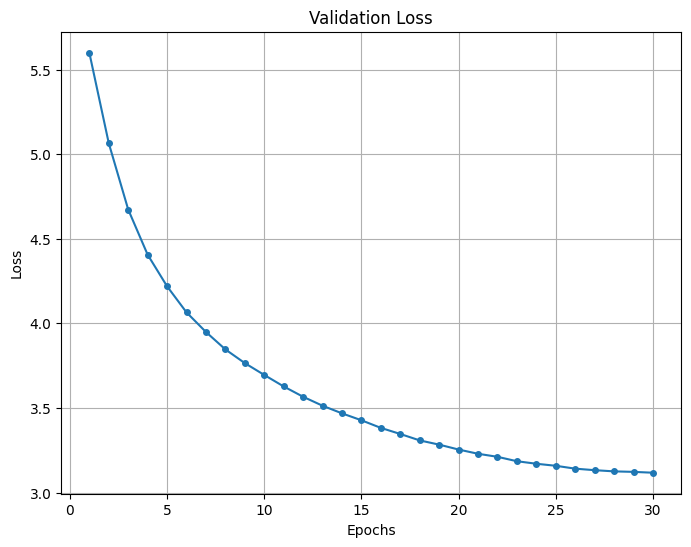

In [52]:
plot_loss(range(1, num_epochs + 1), val_losses, title = 'Validation Loss')

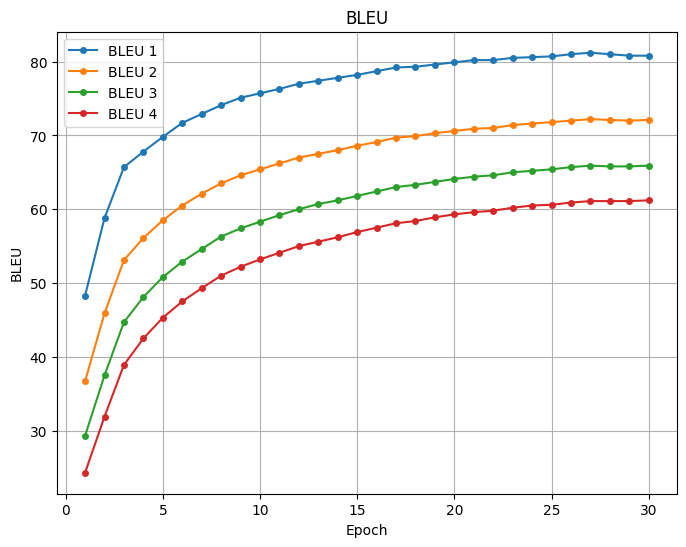

In [53]:
plot_bleu(range(1, num_epochs + 1), val_bleu_1, val_bleu_2, val_bleu_3, val_bleu_4)

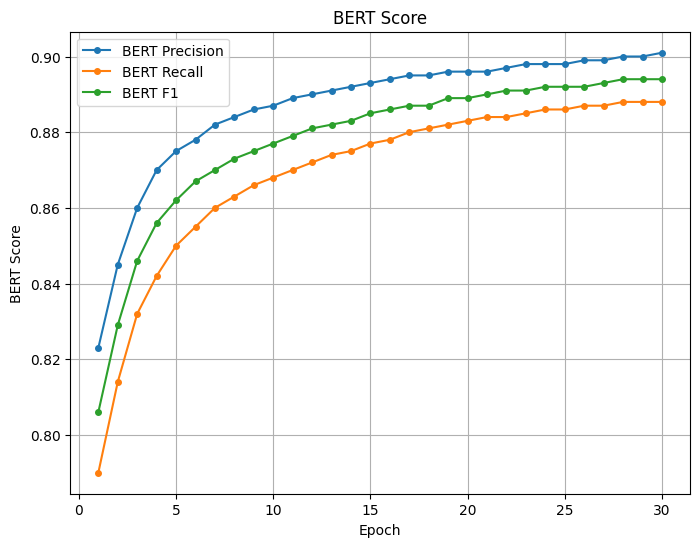

In [54]:
plot_bert_score(range(1, num_epochs + 1), val_bert_precision, val_bert_recall, val_bert_f1)

#### Evaluate

In [56]:
# # Загрузите сохранённые веса
# model.load_state_dict(torch.load('/content/drive/MyDrive/otus_machine_translation/machine_translation_last_30_epochs.pth'))

# # Убедитесь, что модель в режиме оценки (если вы собираетесь делать предсказания)
# model.eval()

In [55]:
test_df = pd.read_csv('/content/drive/MyDrive/otus_machine_translation/multi30k_test.csv')
test_df.head()

,en,de
0,A man in an orange hat starring at something.,"Ein Mann mit einem orangefarbenen Hut, der etw..."
1,A Boston Terrier is running on lush green gras...,Ein Boston Terrier läuft über saftig-grünes Gr...
2,A girl in karate uniform breaking a stick with...,Ein Mädchen in einem Karateanzug bricht ein Br...
3,Five people wearing winter jackets and helmets...,Fünf Leute in Winterjacken und mit Helmen steh...
4,People are fixing the roof of a house.,Leute Reparieren das Dach eines Hauses.


In [57]:
test_df['en_clean'] = test_df['en'].apply(clean_text)
test_df['de_clean'] = test_df['de'].apply(clean_text)
test_df.head()

,en,de,en_clean,de_clean
0,A man in an orange hat starring at something.,"Ein Mann mit einem orangefarbenen Hut, der etw...",a man in an orange hat starring at something,ein mann mit einem orangefarbenen hut der etwa...
1,A Boston Terrier is running on lush green gras...,Ein Boston Terrier läuft über saftig-grünes Gr...,a boston terrier is running on lush green gras...,ein boston terrier läuft über saftig grünes gr...
2,A girl in karate uniform breaking a stick with...,Ein Mädchen in einem Karateanzug bricht ein Br...,a girl in karate uniform breaking a stick with...,ein mädchen in einem karateanzug bricht ein br...
3,Five people wearing winter jackets and helmets...,Fünf Leute in Winterjacken und mit Helmen steh...,five people wearing winter jackets and helmets...,fünf leute in winterjacken und mit helmen steh...
4,People are fixing the roof of a house.,Leute Reparieren das Dach eines Hauses.,people are fixing the roof of a house,leute reparieren das dach eines hauses


In [58]:
test_dataset = CustomDataset(data = test_df,
                          tokenizer_en = tokenizer_en,
                          tokenizer_de = tokenizer_de)
len(test_dataset)

1000

In [59]:
test_batch_size = 32

test_loader = DataLoader(test_dataset,
                         batch_size = test_batch_size,
                         shuffle = False,          # не перемешиваем картинки меду собой в батче
                         drop_last = True)         # удаляем последний пакет данных, если его размер меньше указанного

In [60]:
results = evaluate(model, test_loader, criterion)
results

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'val_loss': 2.541,
 'bleu_1_mean': 83.3,
 'bleu_2_mean': 75.8,
 'bleu_3_mean': 70.39999999999999,
 'bleu_4_mean': 66.4,
 'bert_precision_mean': np.float64(0.913),
 'bert_recall_mean': np.float64(0.906),
 'bert_f1_mean': np.float64(0.909)}

In [61]:
model.generate_translation(source_sentence = 'I love my family',
                           tokenizer_source = tokenizer_en,
                           tokenizer_target = tokenizer_de)

'ich dir ##e familie'

In [62]:
model.generate_translation(source_sentence = 'Two men are at the stove preparing food',
                           tokenizer_source = tokenizer_en,
                           tokenizer_target = tokenizer_de)

'zwei manner auf dem herd bereiten essen zu'

In [63]:
model.generate_translation(source_sentence = 'A little girl climbing into a wooden playhouse.',
                           tokenizer_source = tokenizer_en,
                           tokenizer_target = tokenizer_de)

'ein kleines madchen klettert in ein holz ##ch ##la ##t'

#### Gradio интерфейс

In [65]:
# !pip install gradio

In [66]:
import gradio as gr

In [67]:
# Функция для перевода (замените на вашу реализацию)
def translate_text(english_text):
    # Здесь вызывается ваша модель для перевода
    return model.generate_translation(source_sentence=english_text,
                                      tokenizer_source=tokenizer_en,
                                      tokenizer_target=tokenizer_de)

In [68]:
test_df.loc[460,'en']

'A man sells potatoes to a group of people.'

In [69]:
# Создаем интерфейс Gradio
interface = gr.Interface(
    fn=translate_text,  # Функция для перевода
    inputs=gr.Textbox(label="Английский текст", placeholder="Введите текст на английском..."),
    outputs=gr.Textbox(label="Немецкий перевод"),
    title="Английско-Немецкий Переводчик",
    description="Введите текст на английском и нажмите кнопку для перевода.",
    examples=[
        ["A little girl climbing into a wooden playhouse."],
        ["Two men are working on a construction site."]
    ]
)

# Запускаем интерфейс
interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9f680c07b616c3a9fe.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
